# Example of GECo usage for Graph Classification

## Libraries

In [1]:
import random
import os 
import numpy as np
import torch
import cpuinfo
import platform
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear
import torch.nn as nn
from geco_explainer import GECo

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


## Hyperparameters


In [2]:
seed=0
train_perc=0.8
mini_batch_size=32

## Device Identification

In [3]:

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)


so = platform.system()
if (so == "Darwin"):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    dev_name = cpuinfo.get_cpu_info()["brand_raw"]
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    d = str(device)
    if d == 'cuda':
        dev_name = torch.cuda.get_device_name()
        set_seed(seed)
    else:
        dev_name = cpuinfo.get_cpu_info()["brand_raw"]

print(f"Using {device} - {dev_name}")


Using cuda - NVIDIA GeForce RTX 3090 Ti


## PROTEINS Dataset loading

In [ ]:
root="/tmp/PROTEINS"
dataset=TUDataset(root=root,name="PROTEINS")
print(f"Number of graphs in the dataset: {len(dataset)}")
print(f"Number of classes {dataset.num_classes}")
print(f"Feature Node dimensionality {dataset.num_features}")

train_size = int(train_perc * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
trainloader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
print("Number of graphs in the training set:",len(train_dataset))
print("Number of graphs in the test set:",len(test_dataset))

Processing...


Number of graphs in the dataset: 1113
Number of classes 2
Feature Node dimensionality 3
Number of graphs in the training set: 890
Number of graphs in the test set: 223


Done!


## GNN DEFINITION

In [6]:
class GNN(nn.Module):
    def __init__(self,in_features,hidden_channels,num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)

        return x

## GNN Training 

In [7]:
num_classes = dataset.num_classes
in_features = dataset.num_features
hidden_channels = 64
lr=1e-2
epochs=1000

model = GNN(in_features, hidden_channels, num_classes).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    epoch_loss=0
    for i,data in enumerate(trainloader):
        # Iterate in batches over the training dataset.
        data=data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch+1, epoch_loss))

Epoch 1, loss 0.6767
Epoch 2, loss 0.6720
Epoch 3, loss 0.6450
Epoch 4, loss 0.6386
Epoch 5, loss 0.6271
Epoch 6, loss 0.6111
Epoch 7, loss 0.6109
Epoch 8, loss 0.6092
Epoch 9, loss 0.6202
Epoch 10, loss 0.6106
Epoch 11, loss 0.6052
Epoch 12, loss 0.6045
Epoch 13, loss 0.6141
Epoch 14, loss 0.6017
Epoch 15, loss 0.6183
Epoch 16, loss 0.6110
Epoch 17, loss 0.6004
Epoch 18, loss 0.6060
Epoch 19, loss 0.5977
Epoch 20, loss 0.5981
Epoch 21, loss 0.5973
Epoch 22, loss 0.5987
Epoch 23, loss 0.6152
Epoch 24, loss 0.6030
Epoch 25, loss 0.6013
Epoch 26, loss 0.5957
Epoch 27, loss 0.5972
Epoch 28, loss 0.5967
Epoch 29, loss 0.6019
Epoch 30, loss 0.6024
Epoch 31, loss 0.5972
Epoch 32, loss 0.5978
Epoch 33, loss 0.5937
Epoch 34, loss 0.5990
Epoch 35, loss 0.5996
Epoch 36, loss 0.5944
Epoch 37, loss 0.6015
Epoch 38, loss 0.5931
Epoch 39, loss 0.5954
Epoch 40, loss 0.5958
Epoch 41, loss 0.5905
Epoch 42, loss 0.5953
Epoch 43, loss 0.5945
Epoch 44, loss 0.5869
Epoch 45, loss 0.5950
Epoch 46, loss 0.60

## Explenation Using GECo

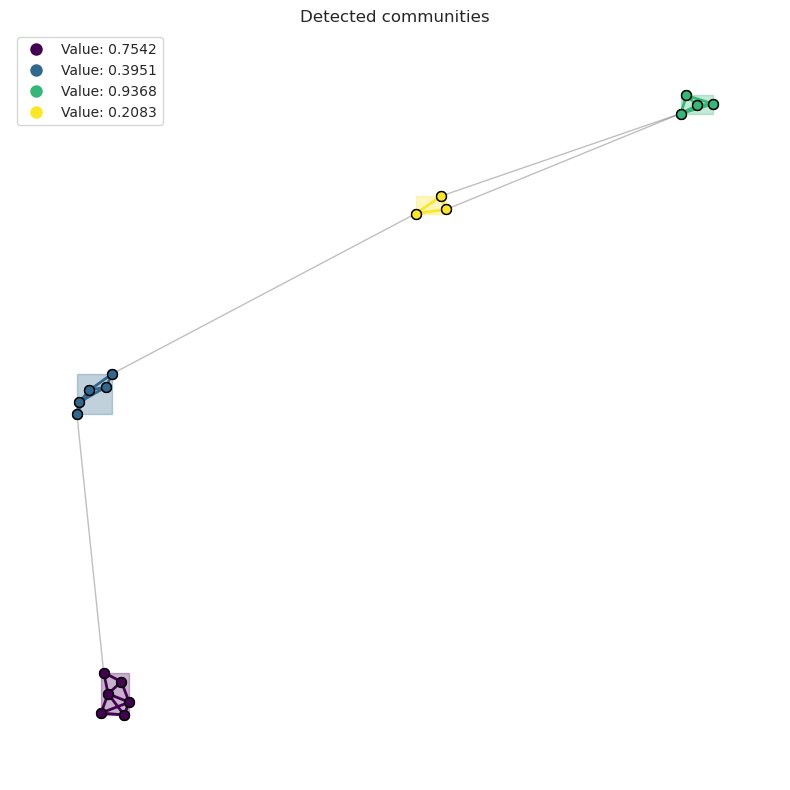

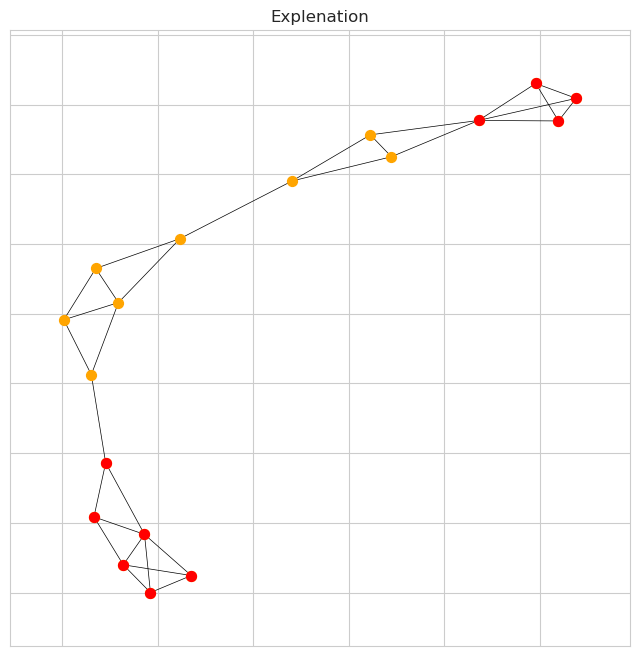

Tau 0.5736037716269493
1. Community [0, 1, 2, 15] (4 nodes) - Probability: 0.9368
2. Community [8, 9, 10, 11, 12, 13] (6 nodes) - Probability: 0.7542
3. Community [16, 17, 6, 7, 14] (5 nodes) - Probability: 0.3951
4. Community [3, 4, 5] (3 nodes) - Probability: 0.2083


In [11]:
geco=GECo(device=device,gnn=model)

graph=test_dataset[10]
pred,_proba=geco.predict(graph)

exp=geco.explain(graph,pred,visualize=True,verbose=True)